# DeepScalper for Algorithm Trading
This tutorial is to demonstrate an example of using DeepScalper to do Algorithms Trading on the Bitcoin

## Set up Experinment Environment

In [1]:
from IPython.display import clear_output
import argparse
import sys
import numpy as np
import torch
from torch import nn
import yaml
import os
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
requirements_path=module_path+"/requirements.txt"
print(requirements_path)
command="pip install -r "+requirements_path
os.system(command)
clear_output(wait=True)
! conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch
clear_output(wait=True)

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.14.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/sunshuo/miniconda3/envs/FinRL

  added / updated specs:
    - cudatoolkit=11.3
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pytorch-1.12.1             |      py3.7_cpu_0        76.6 MB  pytorch
    torchaudio-0.12.1          |         py37_cpu         6.0 MB  pytorch
    torchvision-0.13.1         |         py37_cpu        24.5 MB  pytorch
    ------------------------------------------------------------
                                           Total:       107.1 MB

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2022.6.1~ --> pkgs/mai

## Download and Preprocess the Data
The dataconfig part in TradeMaster is shared by all other parts, it is worth noticing that for algorithms trading, only the dataset BTC is supported.

The following code will help to download the data in the folder [.data/data/BTC](https://github.com/qinmoelei/TradeMaster_reframe/tree/master/tutorial/data/data/BTC), where 4 files could be found: the whole data and train, valid and test data which will be used when we try to construct the RL environment for the agent

In [2]:
from data.download_data import Dataconfig
parser = argparse.ArgumentParser()

parser.add_argument("--data_path",
                    type=str,
                    default="./data/data/",
                    help="the path for storing the downloaded data")
#where we store the dataset
parser.add_argument(
    "--output_config_path",
    type=str,
    default="./config/output_config/data",
    help="the path for storing the generated config file for data")
# where we store the config file
parser.add_argument(
    "--dataset",
    choices=["BTC"],
    default="BTC",
    help="the name of the dataset",
)
parser.add_argument("--split_proportion",
                    type=list,
                    default=[0.8, 0.1, 0.1],
                    help="the split proportion for train, valid and test")
parser.add_argument(
    "--generate_config",
    type=bool,
    default=False,
    help=
    "determine whether to generate a yaml file to memorize the train valid and test'data's dict"
)
parser.add_argument(
    "--input_config",
    type=bool,
    default=False,
    help=
    "determine whether to use a yaml file as the overall input of the Dataconfig, this is needed when have other format of dataset"
)

parser.add_argument(
    "--input_config_path",
    type=str,
    default="config/input_config/data/custom.yml",
    help=
    "determine the location of a yaml file used to initialize the Dataconfig Class"
)
args = parser.parse_args(args=[])
a = Dataconfig(args)


the preprocessed data follows the following structure:


In [3]:
data=pd.read_csv("data/data/BTC/BTC.csv",index_col=0)
data.head(5)

,tic,date,high,low,open,close,adjcp,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
0,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,144.539993,-0.069849,0.020396,-0.072921,0.0,-0.038328,0.234762,0.029592,-0.012624,-0.053283,-0.066832,-0.066352
1,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,139.000000,0.035971,0.057050,-0.035611,0.0,-0.038328,0.234762,0.029592,-0.012624,-0.053283,-0.066832,-0.066352
2,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,116.989998,0.188136,0.195743,-0.079238,0.0,-0.158345,0.234762,0.029592,-0.012624,-0.053283,-0.066832,-0.066352
3,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,105.209999,0.106169,0.193803,-0.122879,0.0,-0.100692,0.234762,0.029592,-0.012624,-0.053283,-0.066832,-0.066352
4,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,97.750000,0.086957,0.106169,-0.190793,0.0,-0.070906,0.234762,0.029592,-0.012624,-0.053283,-0.066832,-0.066352


the index column are corresponding to date one by one and in the algorithm trading case, there is only 1 tic. Besides OHLC, the data also has some normalized features

## RL Enviornment Construction, Agent Training, Model Picking and Testing
For the simplicity, we use the yaml file to store the configuration for the RL environment construction, which can be found [here](https://github.com/qinmoelei/TradeMaster_reframe/tree/master/tutorial/config/input_config/env/AT/DeepScalper)
but first, let us import the package we might use

In [4]:
from env.AT.AT import TradingEnv
from agent.DeepScalper.model import Net
from agent.DeepScalper.dqn import DQN

The rest parameter of the algorithms could be modified through the args displayed followed.

You can find the trained model and test result [here](https://github.com/qinmoelei/TradeMaster_reframe/tree/master/tutorial/result/AT).

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument("--hidden_nodes",
                    type=int,
                    default=256,
                    help="the number of transcation we learn at a time")
parser.add_argument("--batch_size",
                    type=int,
                    default=32,
                    help="the number of transcation we learn at a time")
parser.add_argument("--lr", type=float, default=1e-3, help="the learning rate")
parser.add_argument("--epsilon",
                    type=float,
                    default=0.9,
                    help="the learning rate")
parser.add_argument("--gamma",
                    type=float,
                    default=0.9,
                    help="the learning rate")
parser.add_argument(
    "--target_freq",
    type=int,
    default=50,
    help="the number of updates before the eval could be as same as the target"
)
parser.add_argument(
    "--memory_capacity",
    type=int,
    default=2000,
    help="the number of updates before the eval could be as same as the target"
)
parser.add_argument("--train_env_config",
                    type=str,
                    default="config/input_config/env/AT/DeepScalper/train.yml",
                    help="the dict for storing env config")
parser.add_argument("--valid_env_config",
                    type=str,
                    default="config/input_config/env/AT/DeepScalper/valid.yml",
                    help="the dict for storing env config")
parser.add_argument("--test_env_config",
                    type=str,
                    default="config/input_config/env/AT/DeepScalper/test.yml",
                    help="the dict for storing env config")
parser.add_argument(
    "--future_loss_weights",
    type=float,
    default=0.2,
    help="the weights for future loss",
)
parser.add_argument(
    "--model_path",
    type=str,
    default="result/AT/trained_model",
    help="the path for storing the trained model",
)
parser.add_argument(
    "--result_path",
    type=str,
    default="result/AT/test_result",
    help="the path for storing the test result",
)
args = parser.parse_args(args=[])


In [6]:
def build_agent():
    a = DQN(args)
    return a


def experiment(a: DQN):
    a.train_with_valid(10)
    clear_output(wait=True)
    a.test()


def main():
    a = build_agent()
    experiment(a)

main()

the profit margin is 225.332916000391 %
the sharpe ratio is 0.8607794104103924
the Volatility is 15405.353796230673
the max drawdown is 0.8349657199744575
the Calmar Ratio is 269987.60271368525
the Sortino Ratio is 1.0943025116967398


Here is the process:

We trained model on the train environment for 20 epochs, then when each epoch ends, we use the mdoel to do trading on the valid environment. We use sharpe-ratio as the indicator and choose the best model among 20 models in the valid environment and use the model to do trading in the test environment

Here is what the test result look like:
It contains the total assets and daily return.The difference lies in the transcation fee.

In [7]:
test_result=pd.read_csv("result/AT/test_result/result.csv",index_col=0)
test_result.head(5)

,daily_return,total assets
0,0.000000,100000.000000
1,116.113553,100105.422024
2,355.907811,100450.522076
3,-77.744929,100361.791257
4,-17.616443,100333.214864


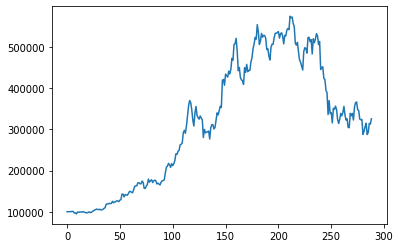

In [8]:
from matplotlib import pyplot as plt
x = range(289)
y = test_result["total assets"].tolist()
plt.plot(x, y)  
plt.show()